In [387]:
from sqlalchemy import create_engine
import pandas as pd
import json
from tqdm.notebook import tqdm
import csv
from rdkit.Chem import AllChem as rdkit
import fnmatch
from collections import defaultdict
from ast import literal_eval
from pathlib import Path
import os
import seaborn as sns
import numpy as np
from  multiprocessing import Pool
from matplotlib import pyplot as plt
import itertools as it
from typing import List
import stk

In [205]:
paper_path = (
    Path.home()
    / "Dropbox"
    / "Apps"
    / "Overleaf"
    / "Synthetic Accessibility Paper - ACS Template"
)
figure_path = paper_path / 'Figures'

In [ ]:
def get_path():
    contains = ["SAScore", "SCScore", "RFModel"]
    fgs = ["Amine", "Aldehyde"]
    for dirpath, dirname, filename in os.walk("."):
        if (
            len(dirpath.split("/")) == 5
            and any(c in dirpath for c in contains)
            and any(fg in dirpath for fg in fgs)
        ):
            yield dirpath

In [ ]:
# For writing molecules to their respective folders.
for path in get_path():
    path = Path(path)
    print(path)
    model_name = path.parents[1].stem.lower()
    dict_ascending = {
        "Lowest": True,
        "Highest": False,
    }
    dict_func_groups = {
        "Amine": "primary amine",
        "Aldehyde": "aldehyde",
    }
    func_group = dict_func_groups[path.stem]
    # Highest and lowest selection.
    if "Highest" in str(path) or "Lowest" in str(path):
        ascending = dict_ascending[path.parents[0].stem]
        with open(str(path.joinpath("Scores.csv")), "w") as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(df_unique_reaxys.columns)
            for i in range(10):
                column = (
                    df_unique_reaxys[df_unique_reaxys["func_group"] == func_group]
                    .sort_values(model_name, ascending=ascending)
                    .iloc[i]
                )
                smiles = column["smiles"]
                mol = rdkit.MolFromSmiles(smiles)
                rdkit.EmbedMolecule(mol)
                rdkit.MolToMolFile(mol, str(path.joinpath(f"{i}.mol")))
                csv_writer.writerow(column.to_list())
    # Median value selection.
    elif "Medium" in str(path):
        with open(str(path.joinpath("Scores.csv")), "w") as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(df_unique_reaxys.columns)
            df_funcgroup = (
                df_unique_reaxys[df_unique_reaxys["func_group"] == func_group]
            )
            df_median = df_funcgroup[df_funcgroup[model_name] == df_funcgroup[model_name].median()].sort_values(model_name)
            df_above_median = df_funcgroup[df_funcgroup[model_name] > df_funcgroup[model_name].median()].sort_values(model_name)[0:4]
            df_below_median = df_funcgroup[df_funcgroup[model_name] < df_funcgroup[model_name].median()].sort_values(model_name, ascending=False)[0:4]
            df_combined = pd.concat([df_above_median, df_below_median, df_median])
            for i in range(len(df_combined)):
                column = df_combined.iloc[i]
                smiles = column["smiles"]
                mol = rdkit.MolFromSmiles(smiles)
                rdkit.EmbedMolecule(mol)
                rdkit.MolToMolFile(mol, str(path.joinpath(f"{i}.mol")))
                csv_writer.writerow(column.to_list())

In [4]:
con = create_engine(
    "sqlite:///Data/Testing_Data/Reaxys_DB_Scored_AddHs.db"
)
df_reaxys = pd.read_sql(sql="synthetic_accesibility", con=con)

In [ ]:
con = create_engine(
    "sqlite:///Data/Testing_Data/Molder_DB_SA_AddHs.db"
)
df_training = pd.read_sql(sql='synthetic_accesibility', con=con)

In [ ]:
df_unique_reaxys = df_reaxys[~df_reaxys['smiles'].isin(df_training['smiles'])].drop_duplicates('smiles')
df_nonunique_reaxys = df_reaxys[df_reaxys['smiles'].isin(df_training['smiles'])]

In [ ]:
# Databases on model trained with no Hs added in the fingerprints.
con = create_engine(
    "sqlite:///Data/Testing_Data/Reaxys_DB_Scored.db"
)
df_reaxys_nohs = pd.read_sql(sql="synthetic_accesibility", con=con)
con = create_engine(
    "sqlite:///Data/Testing_Data/Molder_DB_SA.db"
)
df_training_nohs = pd.read_sql(sql='synthetic_accesibility', con=con)
df_unique_reaxys_nohs = df_reaxys_nohs[~df_reaxys_nohs['smiles'].isin(df_training_nohs['smiles'])]

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_reaxys["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_reaxys["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_reaxys["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Molecules in Reaxys Database / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_reaxys_nohs["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_reaxys_nohs["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_reaxys_nohs["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Molecules in Reaxys Database (no Hs) / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_unique_reaxys["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_unique_reaxys["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_unique_reaxys["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Unique Molecules / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_unique_reaxys_nohs["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_unique_reaxys_nohs["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_unique_reaxys_nohs["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Unique Molecules (noHs) / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_training["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_training["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_training["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Molecules in Training Set / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_training_nohs["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_training_nohs["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_training_nohs["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Molecules in Training Set (noHs) / no units")

In [ ]:
# Testing for duplicates
db = Path.home()/"PhD/main_projects/synthetic_accessibility_project/stages/databases/reaxys_filtered_databases/all_precursors_filtered"
amines = list(db.glob("amine*/*.mol"))

In [ ]:
amines = [rdkit.MolFromMolFile(str(m), removeHs=False) for m in amines]

In [ ]:
amine_smiles = [rdkit.MolToSmiles(m) for m in amines]

In [ ]:
mol_file_to_smiles = lambda m: rdkit.MolToSmiles(rdkit.MolFromMolFile(m))
mol_file_to_smiles_addhs = lambda m: rdkit.MolToSmiles(
    rdkit.MolFromMolFile(m, removeHs=False)
)
mol_file_to_smiles_addhs_nonisomeric = lambda m: rdkit.MolToSmiles(
    rdkit.MolFromMolFile(m, removeHs=False), isomericSmiles=False
)

In [ ]:
dict_amines2f = defaultdict(list)
[dict_amines2f[mol_file_to_smiles(str(p))].append(p) for p in amines]
dict_amines2f_addhs = defaultdict(list)
[dict_amines2f_addhs[mol_file_to_smiles_addhs(str(p))].append(p) for p in amines]

In [ ]:
dupes = list(filter(lambda x: len(x[1]) > 1, dict_amines2f.items()))

In [ ]:
dupes_addhs = list(filter(lambda x: len(x[1]) > 1, dict_amines2f_addhs.items()))

In [ ]:
amines2 = [d for d in dupes if any('amines2f' in x.stem for x in d[1])]

In [ ]:
new = "/Users/stevenbennett/sshfs/stevenbennett@ch-sb2518.ch.ic.ac.uk/"
old = "/Users/stevenbennett/"

In [2]:
reaxys_full = Path(
    "/Users/stevenbennett/Desktop/ga_paper/clean"
)
reaxys_full_amines = list(reaxys_full.glob("amines2f/*.mol"))
reaxys_full_aldehydes = list(reaxys_full.glob("aldehydes3f/*.mol"))

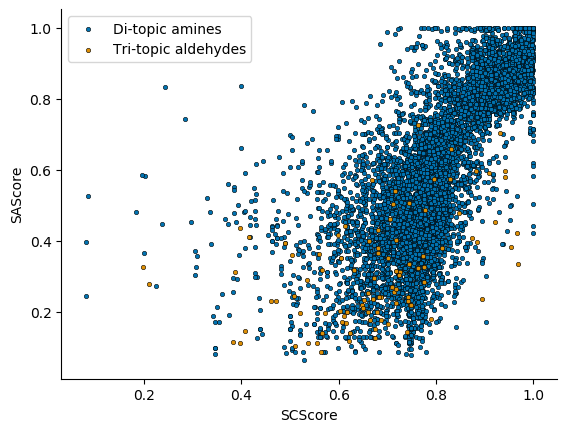

<Figure size 7680x5760 with 0 Axes>

In [207]:
# Plots the graph for Reaxys SA/SC scores.
palette = it.cycle(sns.color_palette('colorblind'))
fig, ax = plt.subplots()
sns.scatterplot(x=df_reaxys[df_reaxys['func_group'] == 'primary amine']['scscore'], y=df_reaxys[df_reaxys['func_group'] == 'primary amine']['sascore'], ax=ax, s=10, edgecolor='black', linewidth=0.4, color=next(palette), label='Di-topic amines')
sns.scatterplot(x=df_reaxys[df_reaxys['func_group'] == 'aldehyde']['scscore'], y=df_reaxys[df_reaxys['func_group'] == 'aldehyde']['sascore'], ax=ax, s=10, edgecolor='black', linewidth=0.4, color=next(palette), label='Tri-topic aldehydes')
ax.set_ylabel('SAScore')
ax.set_xlabel('SCScore')
sns.despine()
plt.figure(dpi=1200)
fig.savefig(figure_path / 'Reaxys_DB_SA_SCScores_FuncGroups.pdf')


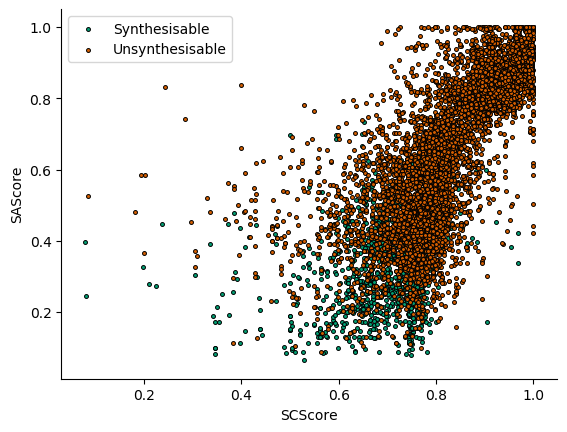

<Figure size 7680x5760 with 0 Axes>

In [209]:
palette = sns.color_palette('colorblind')
fig, ax = plt.subplots()
sns.scatterplot(x=df_reaxys[df_reaxys['rfmodel'] < 0.5]['scscore'], color=palette[2], y=df_reaxys[df_reaxys['rfmodel'] < 0.5]['sascore'], ax=ax, s=8, edgecolor='black', linewidth=0.7, label='Synthesisable')
sns.scatterplot(x=df_reaxys[df_reaxys['rfmodel'] > 0.5]['scscore'], color=palette[3], y=df_reaxys[df_reaxys['rfmodel'] > 0.5]['sascore'], ax=ax, s=8, edgecolor='black', linewidth=0.7, label='Unsynthesisable')
ax.set_ylabel('SAScore')
ax.set_xlabel('SCScore')
sns.despine()
plt.figure(dpi=1200)
fig.savefig(figure_path / 'Reaxys_DB_SA_SCScores_SynthesisableUnsythesisable.pdf')

In [149]:
df_reaxys[df_reaxys['rfmodel'] < 0.5]['sascore'].mean()

0.34882778471433307

In [126]:
palette = sns.color_palette(sns.choose_colorbrewer_palette(data_type='sequential'))

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

In [213]:
df_reaxys.corr('spearman')

,sascore,scscore,rfmodel
sascore,1.000000,0.791552,0.440193
scscore,0.791552,1.000000,0.397294
rfmodel,0.440193,0.397294,1.000000


In [214]:
from scipy.stats import spearmanr

In [244]:
spearmanr(zip(df_reaxys['rfmodel'], df_reaxys['sascore']))

ValueError: `spearmanr` needs at least 2 variables to compare

In [245]:
xint = np.random.randint(10,size=(1000,2))

In [262]:
spearmanr(df_reaxys['rfmodel'].to_list(), df_reaxys['rfmodel'].to_list())

SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)

In [276]:
len(set(df_reaxys[df_reaxys['func_group'] == 'primary amine']['smiles']))

7143

In [265]:
len(df_reaxys[df_reaxys['func_group'] == 'aldehyde'])

98

In [274]:
optimised_cages_path = (
    Path.home()
    / "PhD/main_projects/synthetic_accessibility_project/stages/optimisation_run_0"
)
optimised_cages = [
    stk.ConstructedMolecule.load(str(p)) for p in tqdm(optimised_cages_path.glob("*/*.json"))
]

In [385]:
df_opt_cages = pd.DataFrame({
    'BB1': [rdkit.MolToInchi(bb.to_rdkit_mol()) for cage in tqdm(optimised_cages) for bb in it.islice(cage.get_building_blocks(), 0, 1, 1)],
    'BB2': [rdkit.MolToInchi(bb.to_rdkit_mol()) for cage in tqdm(optimised_cages) for bb in it.islice(cage.get_building_blocks(), 1, 2, 1)],
    'SMILES': [rdkit.MolToInchi(cage.to_rdkit_mol()) for cage in tqdm(optimised_cages)]
})

In [ ]:
combinations = it.product(
    (r[1] for r in df_reaxys[df_reaxys["func_group"] == "primary amine"].iterrows()),
    (r[1] for r in df_reaxys[df_reaxys["func_group"] == "aldehyde"].iterrows()),
)
dict_combinations = defaultdict(list)

for combination in tqdm(combinations):
    dict_combinations["BB"].append(
        rdkit.MolToInchi(rdkit.MolFromSmiles(combination[0]["smiles"]))
        + " "
        + rdkit.MolToInchi(rdkit.MolFromSmiles(combination[1]["smiles"]))
    )
    dict_combinations["SAScore"].append(sum(r["sascore"] for r in combination))
    dict_combinations["SCScore"].append(sum(r["scscore"] for r in combination))
    dict_combinations["RFModel"].append(sum(r["rfmodel"] for r in combination))
df_combinations = pd.DataFrame(dict_combinations)

In [406]:
df_sascore_onepercent = df_combinations[df_combinations['SAScore'] < df_combinations.quantile(.01)['SAScore']]
df_scscore_onepercent = df_combinations[df_combinations['SCScore'] < df_combinations.quantile(.01)['SCScore']]
df_rfmodel_onepercent = df_combinations[df_combinations['RFModel'] < df_combinations.quantile(.01)['RFModel']]

In [416]:
df_combinations

,BB,SAScore,SCScore,RFModel,BB1,BB2
0,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.955902,1.430095,0.908553,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,InChI=1S/C24H15N3O3/c28-13-16-1-7-19(8-2-16)22...
1,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.715132,1.419816,1.247665,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,InChI=1S/C12H12O6/c1-16-10-7(4-13)11(17-2)9(6-...
2,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.837583,1.579785,0.963016,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,"InChI=1S/C45H42O6/c1-43(2,3)37-22-31(19-34(25-..."
3,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.791237,1.026192,1.057077,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,InChI=1S/C27H27NO6/c29-19-22-7-1-4-10-25(22)32...
4,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.732292,1.464902,0.844998,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,InChI=1S/C21H15O7P/c22-13-16-1-7-19(8-2-16)26-...
...,...,...,...,...,...,...
704615,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,1.355153,1.740588,1.249497,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,InChI=1S/C51H36O3/c52-28-34-16-4-1-13-31(34)25...
704616,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,0.954237,1.519338,1.072042,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,InChI=1S/C10H8O3/c1-7-9(5-12)2-8(4-11)3-10(7)6...
704617,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,1.269689,1.688420,0.921803,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,InChI=1S/C27H25NO6/c1-2-33-27(32)4-3-15-34-26-...
704618,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,1.211662,1.592864,0.845188,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,InChI=1S/C21H15NO4/c23-12-15-1-6-18(7-2-15)22(...


In [352]:
list(it.islice(
        df_reaxys[df_reaxys["func_group"] == "primary amine"].iterrows(), 0, 1, 1
    ))

[(98,
  smiles        [H]N([H])C([H])([H])C1([H])C([H])([H])C([H])([...
  func_group                                        primary amine
  sascore                                                0.512767
  scscore                                                0.816976
  rfmodel                                                0.770962
  Name: 98, dtype: object)]

In [433]:
df_opt_cages['BB InChI'] = [r[1]['BB2'] + ' ' + r[1]['BB1'] for r in df_opt_cages.iterrows()]

In [375]:
df_scscore_onepercent[df_scscore_onepercent['BB SMILES'].isin(df_opt_cages['BB SMILES'])]

,BB SMILES,SAScore,SCScore,RFModel


In [381]:
df_reaxys.iloc[0]['smiles']

'[H]C(=O)c1c([H])c([H])c(-c2nc(-c3c([H])c([H])c(C([H])=O)c([H])c3[H])nc(-c3c([H])c([H])c(C([H])=O)c([H])c3[H])n2)c([H])c1[H]'

In [384]:
df_opt_cages.iloc[0]['BB1'] 

False

In [391]:
df_combinations

,BB,SAScore,SCScore,RFModel
0,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.955902,1.430095,0.908553
1,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.715132,1.419816,1.247665
2,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.837583,1.579785,0.963016
3,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.791237,1.026192,1.057077
4,InChI=1S/C13H27N3/c14-9-10-3-1-2-4-13(10)16-12...,0.732292,1.464902,0.844998
...,...,...,...,...
704615,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,1.355153,1.740588,1.249497
704616,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,0.954237,1.519338,1.072042
704617,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,1.269689,1.688420,0.921803
704618,InChI=1S/C28H54N14O9/c1-14(38-22(46)15(30)6-2-...,1.211662,1.592864,0.845188


In [ ]:
df_reaxys['InChI'] = [rdkit.MolToInchi(rdkit.MolFromSmiles(r[1]['smiles'])) for r in df_reaxys.iterrows()]

In [401]:
df_combinations['BB1'] = [r[1]['BB'].split(' ')[0] for r in tqdm(df_combinations.iterrows())]
df_combinations['BB2'] = [r[1]['BB'].split(' ')[1] for r in tqdm(df_combinations.iterrows())]

In [445]:
df_opt_cages[df_opt_cages['BB2'].isin(df_reaxys['InChI'])]

,BB1,BB2,SMILES,BB InChI
1,"InChI=1S/C9H12O5/c1-14-8(13)9(2-5-10,3-6-11)4-...",InChI=1S/C14H22N2O8/c1-5(17)21-11-9(15)12(22-6...,InChI=1S/C120H156N12O56/c1-53(133)165-89-77-95...,InChI=1S/C14H22N2O8/c1-5(17)21-11-9(15)12(22-6...
2,"InChI=1S/C10H14O5/c1-2-15-9(14)10(3-6-11,4-7-1...","InChI=1S/C10H16N2O4/c1-5(13)9(11,6(2)14)10(12,...",InChI=1S/C100H128N12O32/c1-29-141-81(137)85-33...,"InChI=1S/C10H16N2O4/c1-5(13)9(11,6(2)14)10(12,..."
5,"InChI=1S/C9H12O5/c1-14-8(13)9(2-5-10,3-6-11)4-...",InChI=1S/C9H17N3O/c1-2-7-12-9(13)8(11)5-3-4-6-...,InChI=1S/C90H126N18O14/c1-11-47-103-77(109)71-...,InChI=1S/C9H17N3O/c1-2-7-12-9(13)8(11)5-3-4-6-...
6,InChI=1S/C8H7NO3/c1-9-7(4-11)2-6(3-10)8(9)5-12...,InChI=1S/C13H23N5S/c1-2-6-18-12(8-14)16-17-13(...,InChI=1S/C110H142N34S6/c1-11-35-139-99-63-111-...,InChI=1S/C13H23N5S/c1-2-6-18-12(8-14)16-17-13(...
8,InChI=1S/C8H7NO3/c1-9-7(4-11)2-6(3-10)8(9)5-12...,"InChI=1S/C10H18N2O4/c1-6(13)8(11)4-3-5-10(12,7...",InChI=1S/C92H112N16O24/c1-51(109)71-23-17-31-8...,"InChI=1S/C10H18N2O4/c1-6(13)8(11)4-3-5-10(12,7..."
...,...,...,...,...
5125,"InChI=1S/C10H14O5/c1-2-15-9(14)10(3-6-11,4-7-1...","InChI=1S/C4H10N2O/c5-1-4(6)2-7-3-4/h1-3,5-6H2",InChI=1S/C64H92N12O14/c1-5-87-51(77)55-9-21-65...,"InChI=1S/C4H10N2O/c5-1-4(6)2-7-3-4/h1-3,5-6H2 ..."
5132,InChI=1S/C4H4O3/c5-1-4(2-6)3-7/h1-4H,"InChI=1S/C7H16N2/c8-4-6-2-1-3-7(6)5-9/h6-7H,1-...",InChI=1S/C58H88N12/c1-7-47-31-59-19-43-21-61-3...,"InChI=1S/C7H16N2/c8-4-6-2-1-3-7(6)5-9/h6-7H,1-..."
5133,InChI=1S/C8H7NO3/c1-9-7(4-11)2-6(3-10)8(9)5-12...,"InChI=1S/C7H16N2/c8-4-6-2-1-3-7(6)5-9/h6-7H,1-...",InChI=1S/C74H100N16/c1-87-67-24-64-40-76-28-52...,"InChI=1S/C7H16N2/c8-4-6-2-1-3-7(6)5-9/h6-7H,1-..."
5138,"InChI=1S/C10H14O5/c1-2-15-9(14)10(3-6-11,4-7-1...","InChI=1S/C5H12N2/c6-3-4-1-5(7)2-4/h4-5H,1-3,6-...",InChI=1S/C70H104N12O8/c1-5-87-63(83)67-9-21-71...,"InChI=1S/C5H12N2/c6-3-4-1-5(7)2-4/h4-5H,1-3,6-..."


In [441]:
len(df_opt_cages[df_opt_cages['BB InChI'].isin(df_scscore_onepercent['BB'])])

24

In [459]:
from pybel import *

In [460]:
readstring('smiles', 'CCCC')

NameError: name 'readstring' is not defined

In [462]:
from openbabel import pybel

In [468]:
df_reaxys

,smiles,func_group,sascore,scscore,rfmodel,InChI
0,[H]C(=O)c1c([H])c([H])c(-c2nc(-c3c([H])c([H])c...,aldehyde,0.443135,0.613119,0.137591,InChI=1S/C24H15N3O3/c28-13-16-1-7-19(8-2-16)22...
1,[H]C(=O)c1c(OC([H])([H])[H])c(C([H])=O)c(OC([H...,aldehyde,0.202364,0.602840,0.476703,InChI=1S/C12H12O6/c1-16-10-7(4-13)11(17-2)9(6-...
2,[H]Oc1c(C([H])=O)c([H])c(C#Cc2c([H])c(C#Cc3c([...,aldehyde,0.324815,0.762809,0.192054,"InChI=1S/C45H42O6/c1-43(2,3)37-22-31(19-34(25-..."
3,[H]C(=O)c1c([H])c([H])c([H])c([H])c1OC([H])([H...,aldehyde,0.278470,0.209216,0.286115,InChI=1S/C27H27NO6/c29-19-22-7-1-4-10-25(22)32...
4,[H]C(=O)c1c([H])c([H])c(OP(=O)(Oc2c([H])c([H])...,aldehyde,0.219525,0.647926,0.074036,InChI=1S/C21H15O7P/c22-13-16-1-7-19(8-2-16)26-...
...,...,...,...,...,...,...
7283,[H]N=C(N([H])[H])N([H])C([H])([H])C([H])([H])C...,primary amine,0.928227,0.970124,0.789415,InChI=1S/C48H82N18O8/c1-6-28(4)38(46(74)64-36(...
7284,[H]Oc1c([H])c([H])c(C([H])([H])C2([H])C(=O)N([...,primary amine,0.936278,0.956043,0.797883,InChI=1S/C45H63N13O12S2/c46-16-4-8-28(39(64)51...
7285,[H]N=C(N([H])[H])N([H])C([H])([H])C([H])([H])C...,primary amine,0.817022,0.980728,0.807574,InChI=1S/C53H86N16O16/c1-27(2)20-33(64-46(78)3...
7286,[H]N=C(N([H])[H])N([H])C([H])([H])C([H])([H])C...,primary amine,0.910255,0.964836,0.810988,InChI=1S/C47H78N16O9/c1-6-27(4)38(46(72)61-35(...


In [469]:
df_reaxys['InChI OBabel'] = [pybel.readstring('smi', r[1]['smiles']).write('inchi') for r in df_reaxys.iterrows()]

In [476]:
for r in df_reaxys.iterrows():
    if r[1]['InChI'] != r[1]['InChI OBabel']:
        print(r[1]['InChI'])
        print(r[1]['InChI OBabel'])

InChI=1S/C24H15N3O3/c28-13-16-1-7-19(8-2-16)22-25-23(20-9-3-17(14-29)4-10-20)27-24(26-22)21-11-5-18(15-30)6-12-21/h1-15H
InChI=1S/C24H15N3O3/c28-13-16-1-7-19(8-2-16)22-25-23(20-9-3-17(14-29)4-10-20)27-24(26-22)21-11-5-18(15-30)6-12-21/h1-15H

InChI=1S/C12H12O6/c1-16-10-7(4-13)11(17-2)9(6-15)12(18-3)8(10)5-14/h4-6H,1-3H3
InChI=1S/C12H12O6/c1-16-10-7(4-13)11(17-2)9(6-15)12(18-3)8(10)5-14/h4-6H,1-3H3

InChI=1S/C45H42O6/c1-43(2,3)37-22-31(19-34(25-46)40(37)49)13-10-28-16-29(11-14-32-20-35(26-47)41(50)38(23-32)44(4,5)6)18-30(17-28)12-15-33-21-36(27-48)42(51)39(24-33)45(7,8)9/h16-27,49-51H,1-9H3
InChI=1S/C45H42O6/c1-43(2,3)37-22-31(19-34(25-46)40(37)49)13-10-28-16-29(11-14-32-20-35(26-47)41(50)38(23-32)44(4,5)6)18-30(17-28)12-15-33-21-36(27-48)42(51)39(24-33)45(7,8)9/h16-27,49-51H,1-9H3

InChI=1S/C27H27NO6/c29-19-22-7-1-4-10-25(22)32-16-13-28(14-17-33-26-11-5-2-8-23(26)20-30)15-18-34-27-12-6-3-9-24(27)21-31/h1-12,19-21H,13-18H2
InChI=1S/C27H27NO6/c29-19-22-7-1-4-10-25(22)32-16-13-28(14-17-33